In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from typing import Optional

plt.style.use('fivethirtyeight')
sns.set_palette('colorblind')

In [24]:

def get_stock_data(ticker_symbol: str, period: str='1y', interval: str='1d') -> Optional[pd.DataFrame]:
    '''
    Retrieves historical data for a particular stock from Yahoo Finance.
    
    Params:
    ticker_symbol: stock symbol to retrieve
    period: Time period to retrieve (1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max)
    interval: Data interval (1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo)
    
    Returns:
    Dataframe: Historical stock data
    '''
    try:
        ticker = yf.Ticker(ticker_symbol)

        df = ticker.history(period=period, interval=interval)
        
        df = df.reset_index()
        
        if df.empty:
            print(f'No data found for {ticker_symbol}')
            return None
        
        return df
    except Exception as e:
        print(f'Error retrieving data for {ticker_symbol}: {e}')
        return None

def process_time_series(df: pd.DataFrame) -> Optional[pd.DataFrame]:
    '''
    Process time series data for analysis.
    
    Params:
    df: Raw stock data Dataframe
    
    Returns:
    DataFrame: Process Dataframe
    '''
    if df is None or df.empty:
        return None
    
    processed_df = df.copy()
    
    if 'Datetime' in processed_df.columns:
        processed_df = processed_df.rename(columns={'Datetime': 'Date'})
    
    if 'Date' in processed_df.columns:
        processed_df['Date'] = pd.to_datetime(processed_df['Date']) # convert timestamp to pd Datetime object
        processed_df = processed_df.set_index('Date') # set Date as index for time series operations, allows useful datetime attributes
    
    processed_df = processed_df.ffill() # fill missing values using forward fill 
    
    processed_df['DayOfWeek'] = processed_df.index.dayofweek # datetime attribute
    processed_df['Month'] = processed_df.index.month # datetime attribute
    
    return processed_df

def calculate_basic_metrics(df: pd.DataFrame) -> Optional[pd.DataFrame]:
    '''
    Calculates basic metrics and adds their values to the df.
    
    Params:
    df: Process stock data Dataframe
    
    Returns:
    Dataframe: Dataframe with added metrics
    '''
    if df is None or df.empty:
        return None
    
    metrics_df = df.copy()
    
    metrics_df['Daily_Return'] = metrics_df['Close'].pct_change() * 100 # daily return
    
    # calculating cumulative returns based on first day of dataset
    metrics_df['Cum_Return'] = (1 + metrics_df['Daily_Return']/100).cumprod() - 1
    metrics_df['Cum_Return'] = metrics_df['Cum_Return'] * 100 # to pct
    
    # determine volatility (20-day rolling standard deviation of returns), can be added as param in future
    metrics_df['Volatility_20d'] = metrics_df['Daily_Return'].rolling(window=20).std() # rolling uses sliding window approach
    
    # volume changes, volume is total number of shares traded during the day (buy and sell)
    metrics_df['Volume_Change'] = metrics_df['Volume'].pct_change() * 100
    
    # Moving averages for closing prices (5-day, 20-day, and 50-day)
    metrics_df['5d_MA'] = metrics_df['Close'].rolling(window=5).mean()
    metrics_df['20d_MA'] = metrics_df['Close'].rolling(window=20).mean()
    metrics_df['50d_MA'] = metrics_df['Close'].rolling(window=50).mean()
    
    return metrics_df

In [4]:
ticker = 'AAPL'
period = '1y'
interval = '1d'

raw_data = get_stock_data(ticker_symbol=ticker, period=period, interval=interval)
print(f'Raw data shape: {raw_data.shape}')
print('\nRaw data head:')
raw_data.head(10)

Raw data shape: (251, 8)

Raw data head:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2024-04-16 00:00:00-04:00,170.942841,172.943390,167.479200,168.583984,73711200,0.0,0.0
1,2024-04-17 00:00:00-04:00,168.812899,169.848004,167.210464,167.210464,50901200,0.0,0.0
2,2024-04-18 00:00:00-04:00,167.240312,167.847446,165.767272,166.254959,43122900,0.0,0.0
3,2024-04-19 00:00:00-04:00,165.428884,165.617978,163.308889,164.224564,67772100,0.0,0.0
4,2024-04-22 00:00:00-04:00,164.742104,166.473917,163.995629,165.060593,48116400,0.0,0.0
5,2024-04-23 00:00:00-04:00,164.572897,166.264905,164.144910,166.115601,49537800,0.0,0.0
6,2024-04-24 00:00:00-04:00,165.757307,168.504345,165.428871,168.225662,48251800,0.0,0.0
7,2024-04-25 00:00:00-04:00,168.733275,169.808201,167.359755,169.091583,50558300,0.0,0.0
8,2024-04-26 00:00:00-04:00,169.081625,170.534755,168.384902,168.504349,44838400,0.0,0.0
9,2024-04-29 00:00:00-04:00,172.555207,175.202709,172.286487,172.684601,68169400,0.0,0.0


In [5]:
processed_data = process_time_series(raw_data)
print('Processed data head:')
processed_data.head(10)

Processed data head:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,DayOfWeek,Month
Date,,,,,,,,,
2024-04-16 00:00:00-04:00,170.942841,172.943390,167.479200,168.583984,73711200,0.0,0.0,1,4
2024-04-17 00:00:00-04:00,168.812899,169.848004,167.210464,167.210464,50901200,0.0,0.0,2,4
2024-04-18 00:00:00-04:00,167.240312,167.847446,165.767272,166.254959,43122900,0.0,0.0,3,4
2024-04-19 00:00:00-04:00,165.428884,165.617978,163.308889,164.224564,67772100,0.0,0.0,4,4
2024-04-22 00:00:00-04:00,164.742104,166.473917,163.995629,165.060593,48116400,0.0,0.0,0,4
2024-04-23 00:00:00-04:00,164.572897,166.264905,164.144910,166.115601,49537800,0.0,0.0,1,4
2024-04-24 00:00:00-04:00,165.757307,168.504345,165.428871,168.225662,48251800,0.0,0.0,2,4
2024-04-25 00:00:00-04:00,168.733275,169.808201,167.359755,169.091583,50558300,0.0,0.0,3,4
2024-04-26 00:00:00-04:00,169.081625,170.534755,168.384902,168.504349,44838400,0.0,0.0,4,4


In [6]:
metrics_data = calculate_basic_metrics(processed_data)
print('Data with metrics head:')
metrics_data.head(10)

Data with metrics head:


,Open,High,Low,Close,Volume,Dividends,Stock Splits,DayOfWeek,Month,Daily_Return,Cum_Return,Volatility_20d,Volume_Change,5d_MA,20d_MA,50d_MA
Date,,,,,,,,,,,,,,,,
2024-04-16 00:00:00-04:00,170.942841,172.943390,167.479200,168.583984,73711200,0.0,0.0,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-17 00:00:00-04:00,168.812899,169.848004,167.210464,167.210464,50901200,0.0,0.0,2,4,-0.814739,-0.814739,NaN,-30.945094,NaN,NaN,NaN
2024-04-18 00:00:00-04:00,167.240312,167.847446,165.767272,166.254959,43122900,0.0,0.0,3,4,-0.571439,-1.381522,NaN,-15.281172,NaN,NaN,NaN
2024-04-19 00:00:00-04:00,165.428884,165.617978,163.308889,164.224564,67772100,0.0,0.0,4,4,-1.221254,-2.585904,NaN,57.160349,NaN,NaN,NaN
2024-04-22 00:00:00-04:00,164.742104,166.473917,163.995629,165.060593,48116400,0.0,0.0,0,4,0.509077,-2.089992,NaN,-29.002643,166.266913,NaN,NaN
2024-04-23 00:00:00-04:00,164.572897,166.264905,164.144910,166.115601,49537800,0.0,0.0,1,4,0.639164,-1.464186,NaN,2.954086,165.773236,NaN,NaN
2024-04-24 00:00:00-04:00,165.757307,168.504345,165.428871,168.225662,48251800,0.0,0.0,2,4,1.270237,-0.212548,NaN,-2.595997,165.976276,NaN,NaN
2024-04-25 00:00:00-04:00,168.733275,169.808201,167.359755,169.091583,50558300,0.0,0.0,3,4,0.514738,0.301096,NaN,4.780133,166.543600,NaN,NaN
2024-04-26 00:00:00-04:00,169.081625,170.534755,168.384902,168.504349,44838400,0.0,0.0,4,4,-0.347288,-0.047238,NaN,-11.313474,167.399557,NaN,NaN


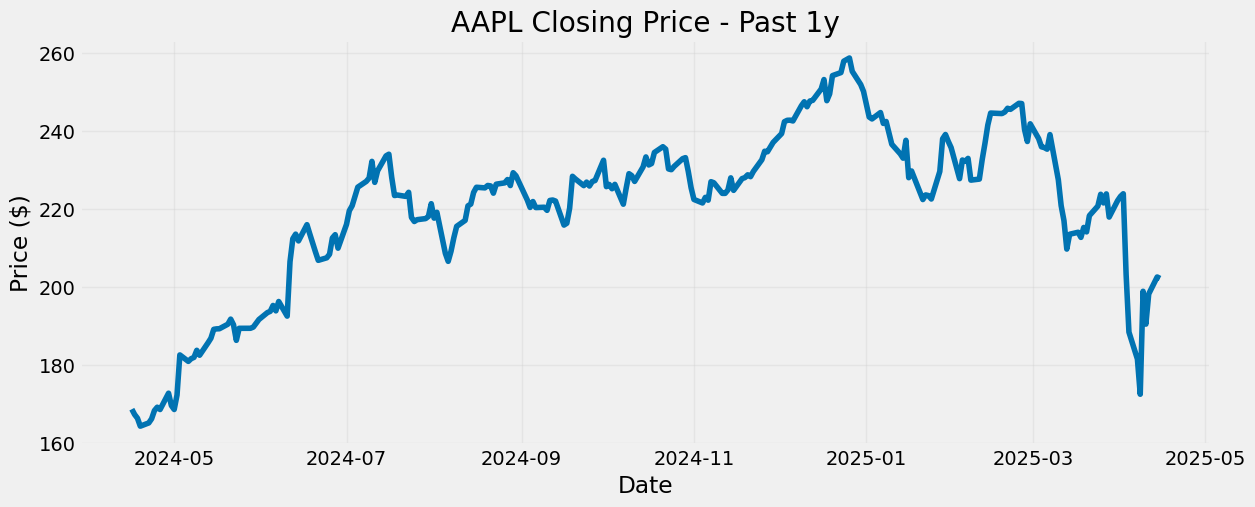

In [7]:
# plot closing prices
plt.figure(figsize=(13, 5))
plt.plot(metrics_data.index, metrics_data['Close'])
plt.title(f'{ticker} Closing Price - Past {period}')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

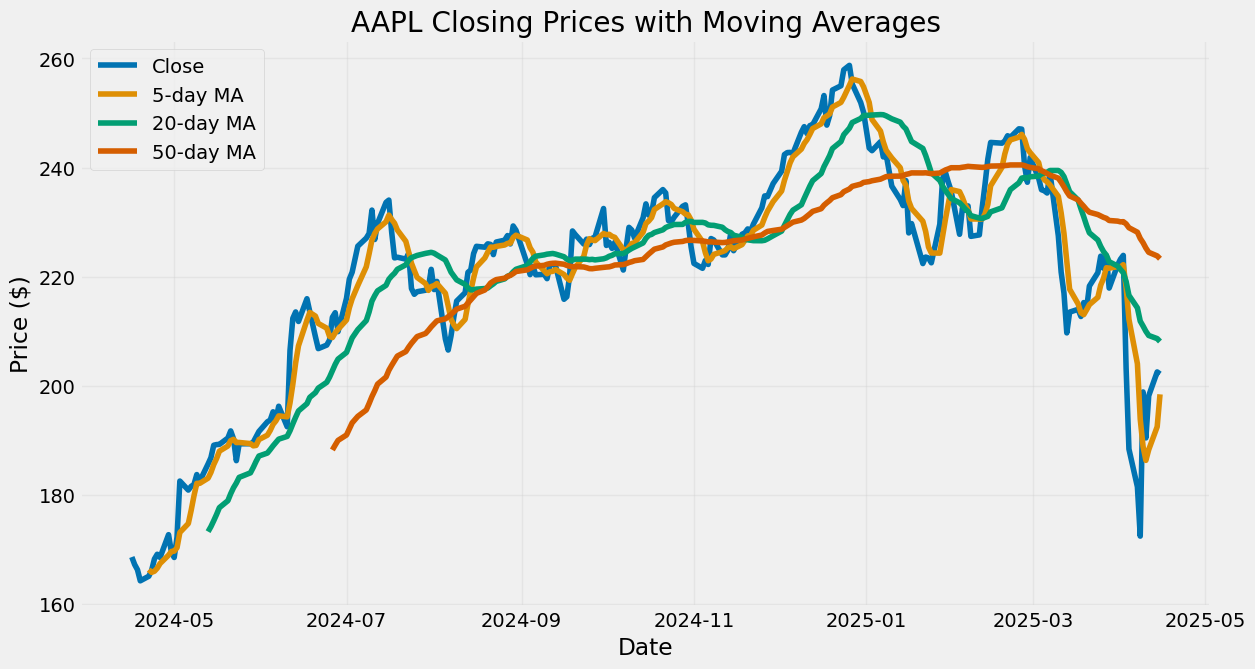

In [8]:
plt.figure(figsize=(13, 7))
plt.plot(metrics_data.index, metrics_data['Close'], label='Close')
plt.plot(metrics_data.index, metrics_data['5d_MA'], label='5-day MA')
plt.plot(metrics_data.index, metrics_data['20d_MA'], label='20-day MA')
plt.plot(metrics_data.index, metrics_data['50d_MA'], label='50-day MA')
plt.title(f'{ticker} Closing Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1500x1100 with 0 Axes>

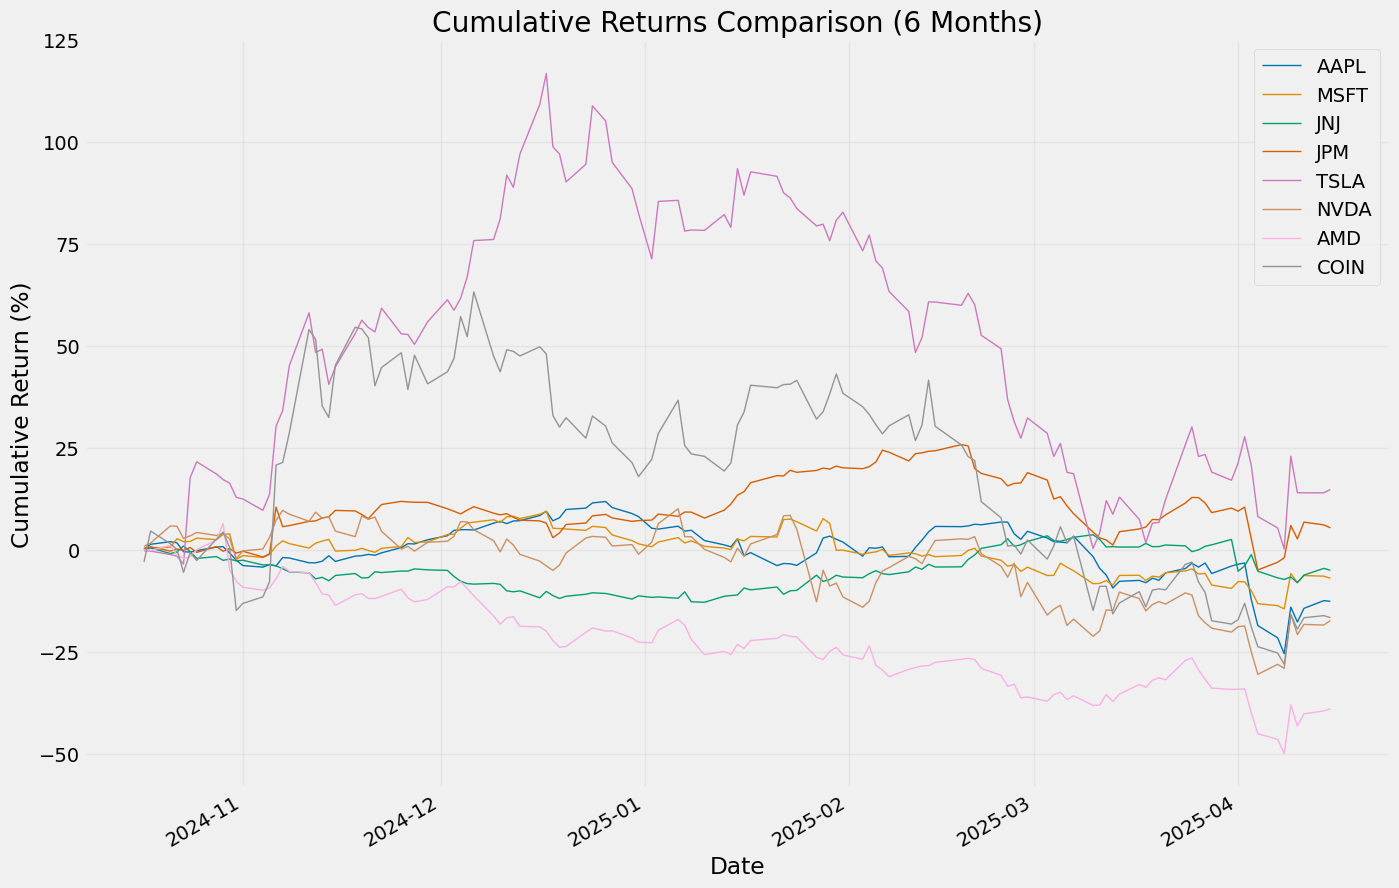

In [9]:
# comparing selected stocks
tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'TSLA', 'NVDA', 'AMD', 'COIN']
comparison_data = {}

for ticker in tickers:
    data = get_stock_data(ticker_symbol=ticker, period='6mo', interval='1d')
    if data is not None:
        processed = process_time_series(data)
        metrics = calculate_basic_metrics(processed)
        comparison_data[ticker] = metrics['Cum_Return']

# create dataframe object
comparison_df = pd.DataFrame(comparison_data)

# plot
plt.figure(figsize=(15, 11))
comparison_df.plot(figsize=(15, 11), linewidth=1)
plt.title('Cumulative Returns Comparison (6 Months)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
# Questions to answer in following cell:
# How does the stock's price movement compare to its moving averages? (Trend identification)
# What patterns do you see in the trading volume? (Market interest)
# How are the daily returns distributed? (Risk assessment)
# Which stocks show the highest volatility? (Risk comparison)
# Are there any notable correlations between the stocks in your selection?

In [28]:
# I will look at the TSLA stock in particular
# first let's set up the dataframe

tsla_6mo_1d = get_stock_data(ticker_symbol='TSLA', period='6mo', interval='1d')
tsla_5d_90m = get_stock_data(ticker_symbol='TSLA', period='5d', interval='90m')

tsla_6mo_1d = process_time_series(tsla_6mo_1d)
tsla_5d_90m = process_time_series(tsla_5d_90m)

tsla_6mo_1d = calculate_basic_metrics(tsla_6mo_1d)
tsla_5d_90m = calculate_basic_metrics(tsla_5d_90m)

print('Valid columns to look at:\n')
print(f'tsla_6mo_1d: {tsla_6mo_1d.columns}\n')
print(f'tsla_5d_90m: {tsla_5d_90m.columns}\n')

tsla_5d_90m.head() # noticed that for some reason using this period/interval makes the 'Date' column called Datetime. Quick fix.


Valid columns to look at:

tsla_6mo_1d: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'DayOfWeek', 'Month', 'Daily_Return', 'Cum_Return', 'Volatility_20d',
       'Volume_Change', '5d_MA', '20d_MA', '50d_MA'],
      dtype='object')

tsla_5d_90m: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'DayOfWeek', 'Month', 'Daily_Return', 'Cum_Return', 'Volatility_20d',
       'Volume_Change', '5d_MA', '20d_MA', '50d_MA'],
      dtype='object')



,Open,High,Low,Close,Volume,Dividends,Stock Splits,DayOfWeek,Month,Daily_Return,Cum_Return,Volatility_20d,Volume_Change,5d_MA,20d_MA,50d_MA
Date,,,,,,,,,,,,,,,,
2025-04-09 09:30:00-04:00,224.562500,234.651199,223.889999,226.793198,54422376,0.0,0.0,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-09 11:00:00-04:00,226.850006,233.830002,226.630005,232.654999,23276447,0.0,0.0,2,4,2.584646,2.584646,NaN,-57.230006,NaN,NaN,NaN
2025-04-09 12:30:00-04:00,232.610001,260.559998,231.869995,260.095398,47049403,0.0,0.0,2,4,11.794459,14.683950,NaN,102.133096,NaN,NaN,NaN
2025-04-09 14:00:00-04:00,260.160004,269.209900,256.500000,268.480011,51245797,0.0,0.0,2,4,3.223668,18.380980,NaN,8.919123,NaN,NaN,NaN
2025-04-09 15:30:00-04:00,268.459991,274.690002,267.200012,272.000000,20202687,0.0,0.0,2,4,1.311080,19.933050,NaN,-60.576890,252.004721,NaN,NaN


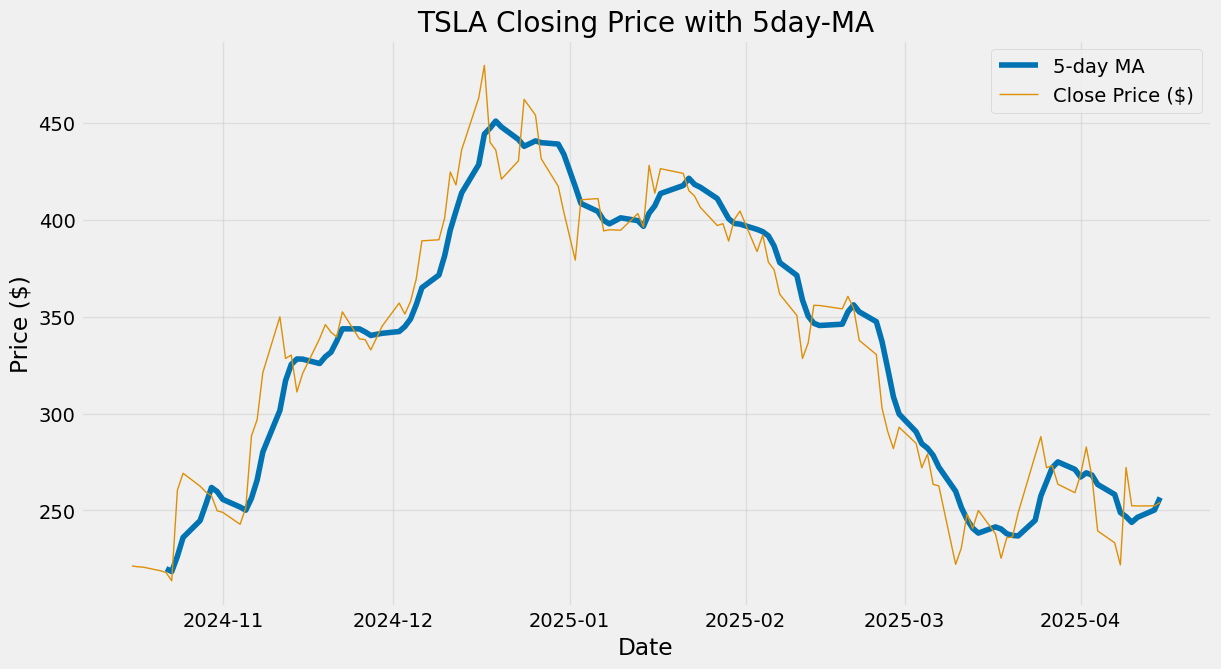

In [31]:
# let's first look at plotting price movement and MA, 
plt.figure(figsize=(13, 7))
plt.plot(tsla_6mo_1d.index, tsla_6mo_1d['5d_MA'], label='5-day MA')
plt.plot(tsla_6mo_1d.index, tsla_6mo_1d['Close'], label='Close Price ($)', linewidth=1)
plt.title('TSLA Closing Price with 5day-MA')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

## We notice that the MA captures a more overall trend of how the price moves and avoids a more volatile display of the performance of the stock. This to me suggests that 
# using moving averages would likely be more beneficialo when we are doing some sort of analysis that requires a more hollistic approach, whereas approches that require
# more granular and identification of rapid price changes (perhaps High-Frequency Trading for example) would avoid moving averages.

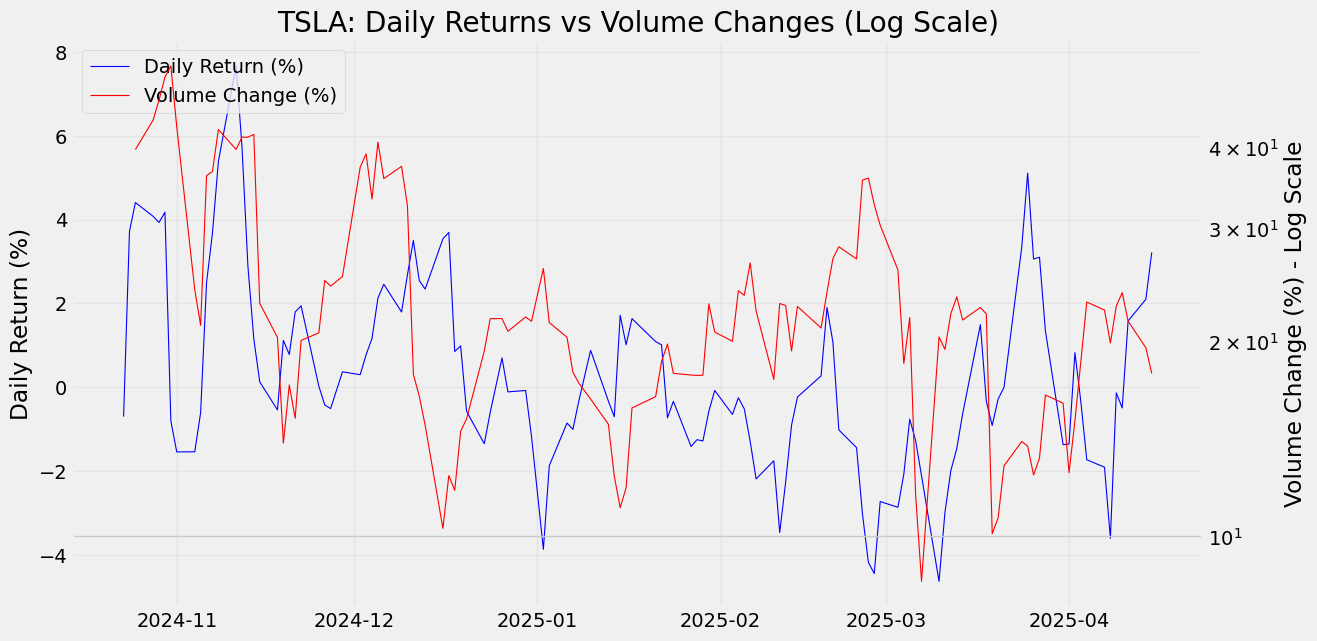

In [39]:
plt.figure(figsize=(13, 7))

ax1 = plt.gca()
smoothed_returns = tsla_6mo_1d['Daily_Return'].rolling(window=5).mean()
ax1.plot(
    tsla_6mo_1d.index, smoothed_returns,
    label='Daily Return (%)', linewidth=0.8, color='blue')
ax1.set_ylabel('Daily Return (%)')

ax2 = plt.twinx()
ax2.set_yscale('log')
smoothed_volume = abs(tsla_6mo_1d['Volume_Change']).rolling(window=7).mean()
ax2.plot(
    tsla_6mo_1d.index, smoothed_volume,
    label='Volume Change (%)', linewidth=0.8, color='red'
)
ax2.set_ylabel('Volume Change (%) - Log Scale')

# Title and grid
plt.title('TSLA: Daily Returns vs Volume Changes (Log Scale)')
ax1.grid(True, alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

# my assumption here is that we might see larger changes in volume when the given stock is more volatile as prices start to adjust
# changed to using log scale for change in volume due to difference in magnitudes

# I would say that the relation is not as clear as I would of thought, but I would argue that there is a relationship to be found

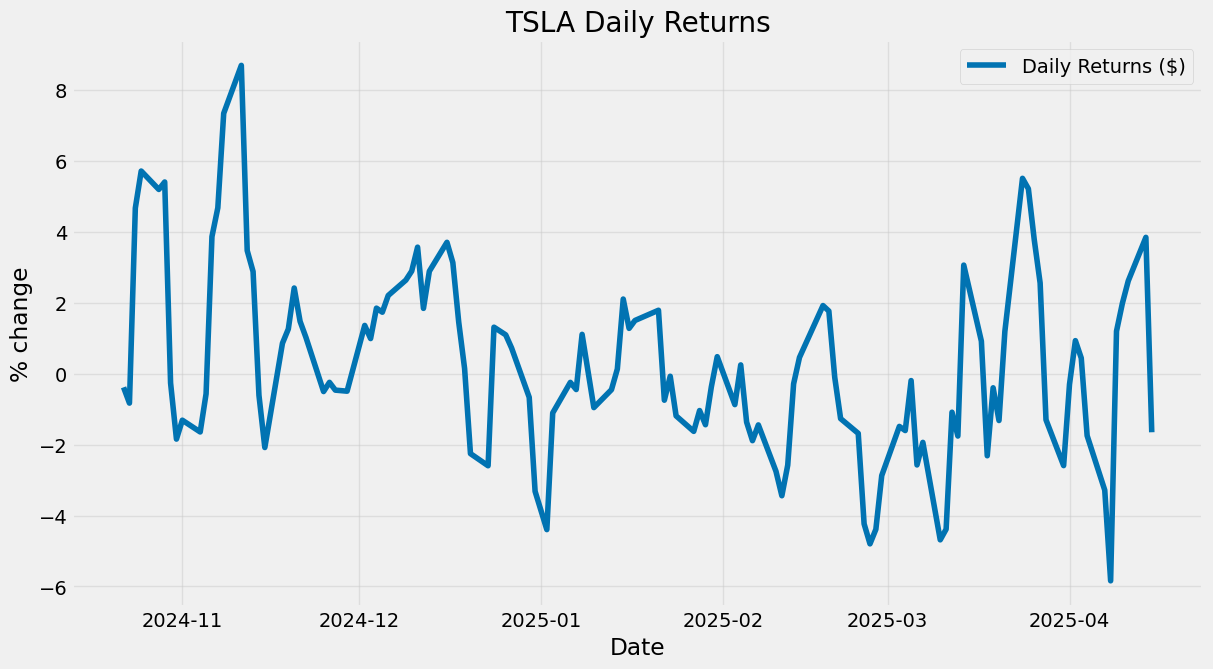

In [49]:
plt.figure(figsize=(13, 7))
smoothed_returns = tsla_6mo_1d['Daily_Return'].rolling(window=4).mean()
plt.plot(tsla_6mo_1d.index, smoothed_returns, label='Daily Returns ($)')
plt.title('TSLA Daily Returns')
plt.xlabel('Date')
plt.ylabel('% change')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# We see that the daily returns are very volatile and thus we should be able to say that the stock currently seems to have 
# a slightly risky profile. Based on the graph, it does look like that if we aggregate the daily returns, we can say that
# the overall return is positive, however very slightly so.

<Figure size 1500x1100 with 0 Axes>

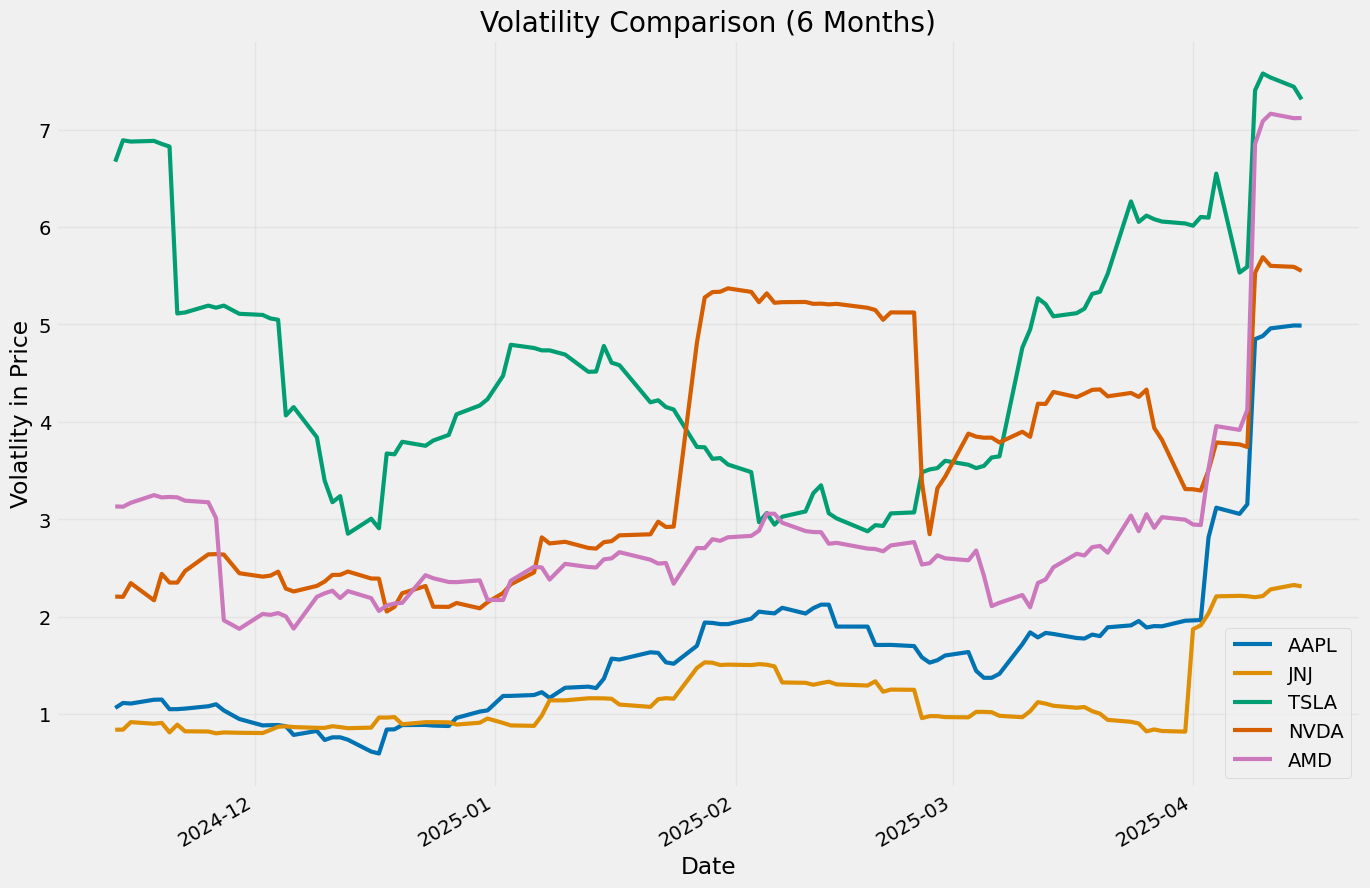

In [54]:
# comparing selected stocks
tickers = ['AAPL', 'JNJ', 'TSLA', 'NVDA', 'AMD']
comparison_data = {}

for ticker in tickers:
    data = get_stock_data(ticker_symbol=ticker, period='6mo', interval='1d')
    if data is not None:
        processed = process_time_series(data)
        metrics = calculate_basic_metrics(processed)
        comparison_data[ticker] = metrics['Volatility_20d']

# create dataframe object
comparison_df = pd.DataFrame(comparison_data)

# plot
plt.figure(figsize=(15, 11))
comparison_df.plot(figsize=(15, 11), linewidth=3)
plt.title('Volatility Comparison (6 Months)')
plt.xlabel('Date')
plt.ylabel('Volatlity in Price')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# This plot provides an interesting insight on how events influence stock prices/volatility. Firstly we see a massive 
# jump in volatility in the past few weeks due to the tariffs affecting input costs
# we also see that that Tesla has had relatively high volatility over the period, likely due to Elon Musk's association
# with the Trump admin. and thus his actions reflecting sentiment on the company.
# Additionally we see that Nvidia had a massive jump in volatility during the month of february. I think this is linked to 
# the release of Deepseek and thus the loss in perceived value of the company.